In [1]:
import autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
import os

import time
import progressbar
import warnings
import copy
import pandas as pd
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

import torch
import torch.utils.data as utils
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.nn import ReLU

from multiprocessing import cpu_count
from torch.multiprocessing import Pool

%matplotlib inline
plt.style.use('seaborn')

warnings.filterwarnings("ignore")
torch.set_num_threads(1)

In [3]:
def read_data_from_csv(path):
    df = pd.read_csv(path)
    X = df["sequence"].values
    y = df["label"].values
    y_names = df["class_name"].values
    return X, y, y_names

In [4]:
def load_train_val_test_data(level, analyze=True, return_label_names=False):
    data_base_path = "../data/hierarchy/" + level
    train_sequences, train_labels, train_label_names = read_data_from_csv(os.path.join(data_base_path, "train.csv"))
    val_sequences, val_labels, val_label_names = read_data_from_csv(os.path.join(data_base_path, "val.csv"))
    test_sequences, test_labels, test_label_names = read_data_from_csv(os.path.join(data_base_path, "test.csv"))
    
    if analyze:
        a = list(map(lambda x: len(x), train_sequences))
        print("DNA Sequence Length Statistics:")
        print("Max:", np.max(a))
        print("Min:", np.min(a))
        print("Mean:", np.ceil(np.mean(a)))
        print("Median:", np.ceil(np.median(a)))
        print("Sqrt of Max:", np.ceil(np.sqrt(np.max(a))))
    if return_label_names:
        return train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels, test_label_names
    return train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels

In [5]:
IMAGE_WIDTH = IMAGE_HEIGHT = 21  # 441 length zero-padded DNA sequences
IMAGE_CHANNELS = 4  # A, C, G, T

base_pair_map = {
    'A': [1, 0, 0, 0],
    'C': [0, 1, 0, 0],
    'G': [0, 0, 1, 0],
    'T': [0, 0, 0, 1],
    'X': [0, 0, 0, 0]
}

def seqeunces_to_image(sequences):
    image = np.zeros((len(sequences), IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
    for i, sequence in enumerate(sequences):
        for loc, base_pair in enumerate(sequence):
            row = loc // IMAGE_HEIGHT
            col = loc % IMAGE_HEIGHT
            image[i, row, col] = base_pair_map[base_pair]
    return image

In [6]:
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(5*5*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = F.log_softmax(self.fc(out), dim=1)
        return out

## Load all pretrained models

In [15]:
phylum_trained_model = ConvNet(3)
phylum_trained_model.load_state_dict(torch.load("../results/cnn/models/best_phylum_cnn_model"))

class_trained_model = ConvNet(5)
class_trained_model.load_state_dict(torch.load("../results/cnn/models/best_class_cnn_model"))

order_trained_model = ConvNet(10)
order_trained_model.load_state_dict(torch.load("../results/cnn/models/best_order_cnn_model"))

# Visualize the First Convolution Layer's Learned Activations

In [8]:
"""
Modified code form @author: Utku Ozbulak - github.com/utkuozbulak
"""

class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        # Register hook to the first layer
        first_layer = list(self.model.layer1._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

        # Loop through layers, hook up ReLUs
        for pos, module in self.model.layer1._modules.items():
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward pass
        model_output = self.model(input_image)
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr

In [9]:
## Helpers
def convert_gradient_to_image(gradient):
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()

    if gradient.shape[0] == 3 and np.max(gradient) == 1:
        gradient = gradient.transpose(1, 2, 0) * 255
    elif gradient.shape[0] == 3 and np.max(gradient) > 1:
        gradient = gradient.transpose(1, 2, 0)

    gradient = gradient.astype(np.uint8)
    gradient = Image.fromarray(gradient)

    with BytesIO() as f:
        gradient.save(f, format='JPEG')
        f.seek(0)
        return np.array(Image.open(BytesIO(f.read())))

def get_positive_negative_saliency(gradient):
    pos_saliency = (np.maximum(0, gradient) / gradient.max())
    neg_saliency = (np.maximum(0, -gradient) / -gradient.min())
    return pos_saliency, neg_saliency

In [16]:
def load_data_for_activations_viz(level, num_samples_per_class=10):
    _, _, _, _, test_sequences, test_labels, test_label_names = load_train_val_test_data(level, analyze=False, return_label_names=True)
    test_data = seqeunces_to_image(test_sequences)
    data = dict()
    label_map = dict()
    for label in np.unique(test_labels):
        choosen = np.random.choice(np.argwhere(test_labels == label).flatten(), num_samples_per_class, replace=False)
        sub_data = test_data[choosen]
        label_name = np.unique(test_label_names[choosen])[0]
        data[label] = sub_data
        label_map[label] = label_name
    return data, label_map

In [17]:
def get_activation_map(input_image, level, class_id):
    # prepare input image
    input_image = input_image.transpose(2, 0, 1)
    input_image = torch.from_numpy(input_image).float()
    input_image.unsqueeze_(0)
    input_image = Variable(input_image, requires_grad=True)

    # Init Guided Backprop
    if level == "phylum":
        model = phylum_trained_model
    elif level == "class":
        model = class_trained_model
    else:
        model = order_trained_model

    GBP = GuidedBackprop(model)

    # Get Gradients (clip to just 3 of 4 channels)
    guided_gradients = GBP.generate_gradients(input_image, class_id)[:3, :, :]

    # Negative Saliency Maps
    _, neg_sal = get_positive_negative_saliency(guided_gradients)

    activation_map_image = convert_gradient_to_image(_)
    # plt.imshow(activation_image)
    
    return activation_map_image

In [18]:
def plot_activation_maps(level, class_id, class_name, data):
    fig = plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.grid(b=None)

    rc = int(np.ceil(np.sqrt(len(data))))
    for i, d in enumerate(data):
        image = get_activation_map(d, level, class_id)
        ax = fig.add_subplot(rc, rc, i+1)
        ax.grid(False)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.imshow(image)

    fig.suptitle(level.capitalize() + "-level Activations (1st layer) for " + class_name, fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [19]:
def viz_activations_for(level, num_samples_per_class=25):
    category_wise_data, categories = load_data_for_activations_viz(level, num_samples_per_class)
    for c in categories:
        plot_activation_maps(level, c, categories[c], category_wise_data[c])

## Phylum-level

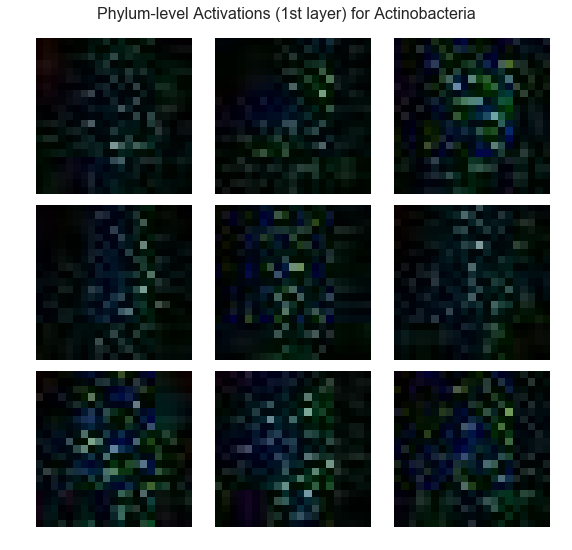

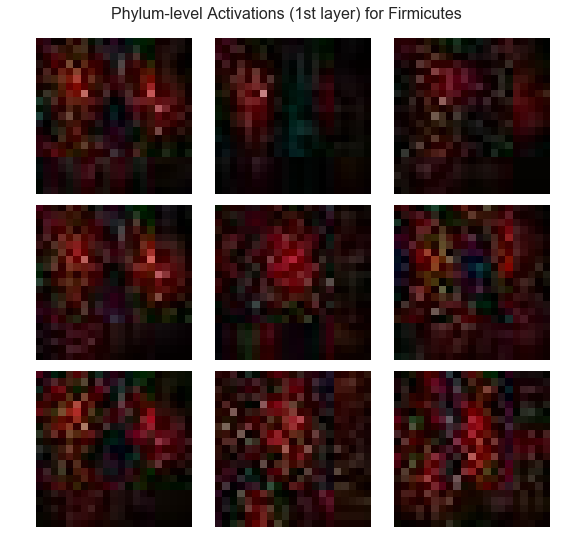

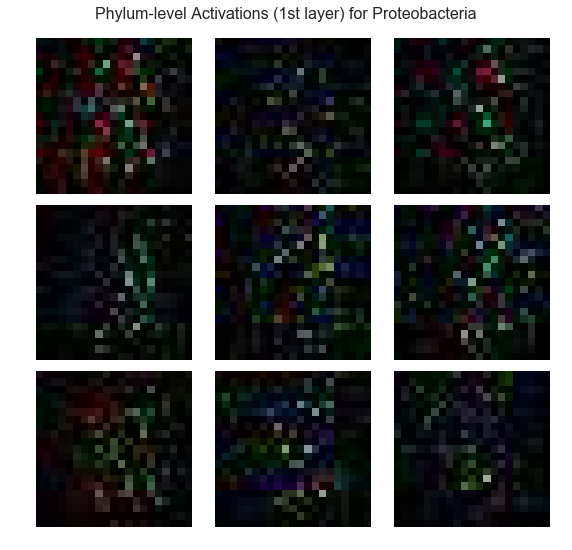

In [20]:
viz_activations_for("phylum", num_samples_per_class=9)

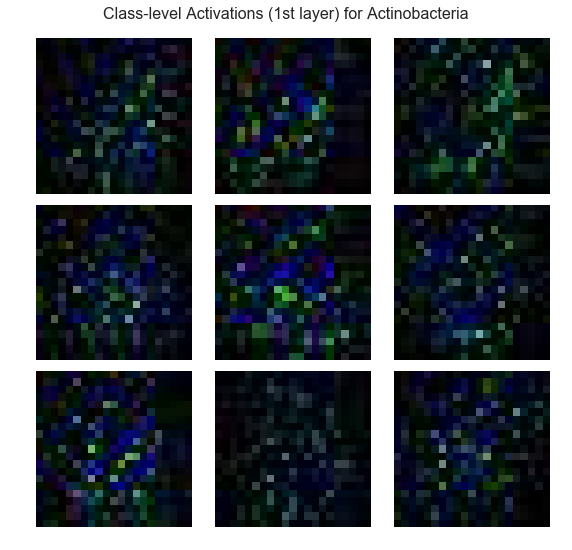

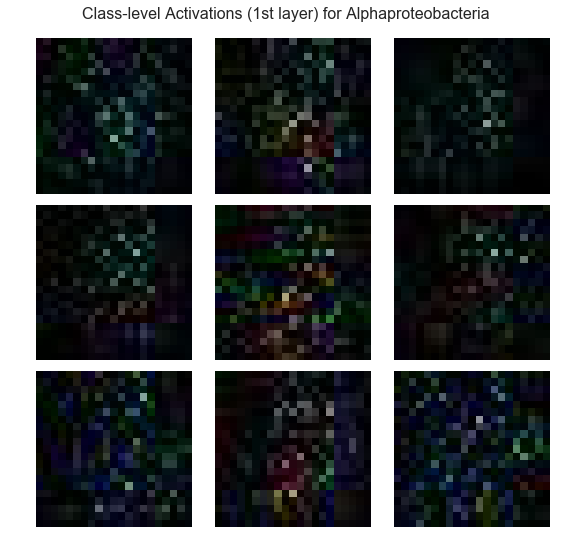

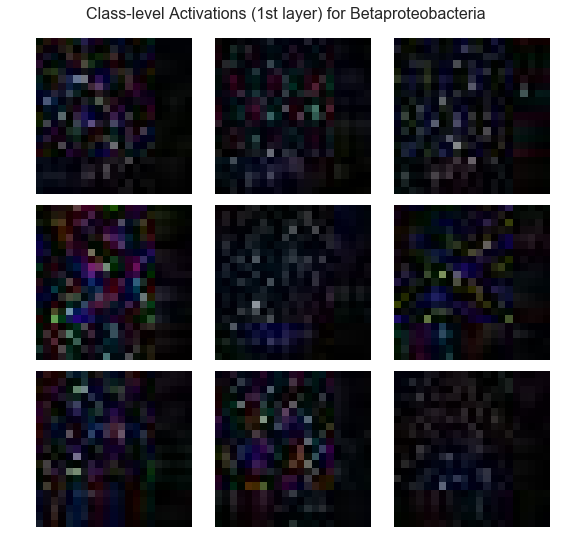

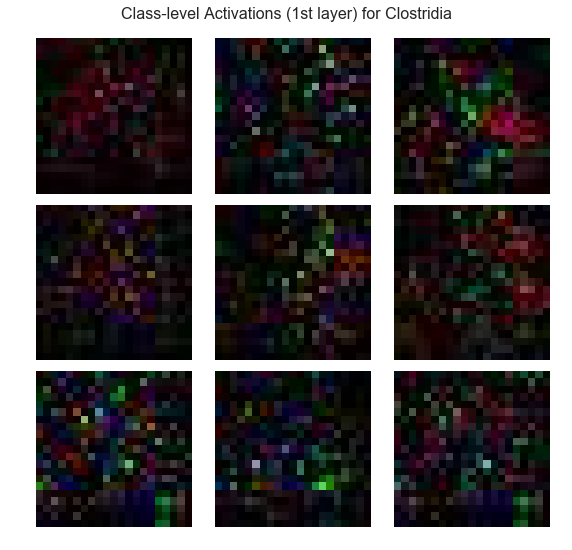

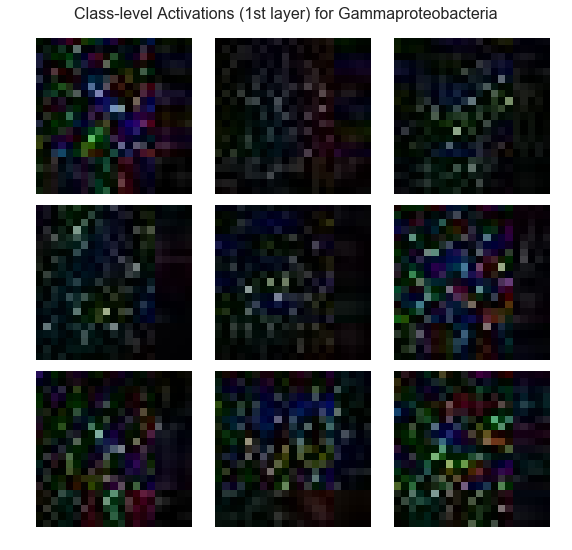

In [21]:
viz_activations_for("class", num_samples_per_class=9)

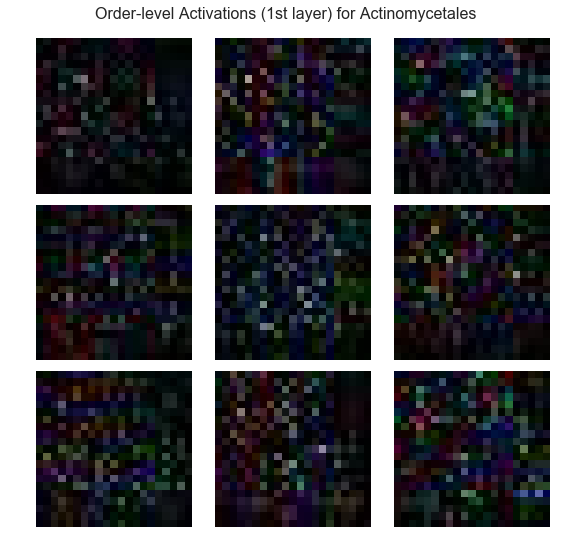

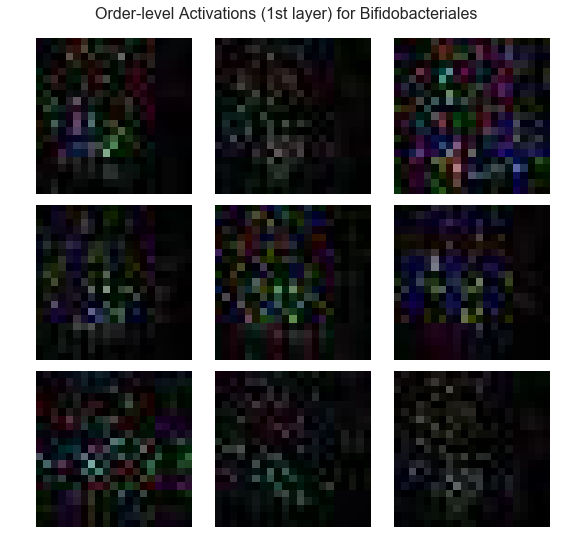

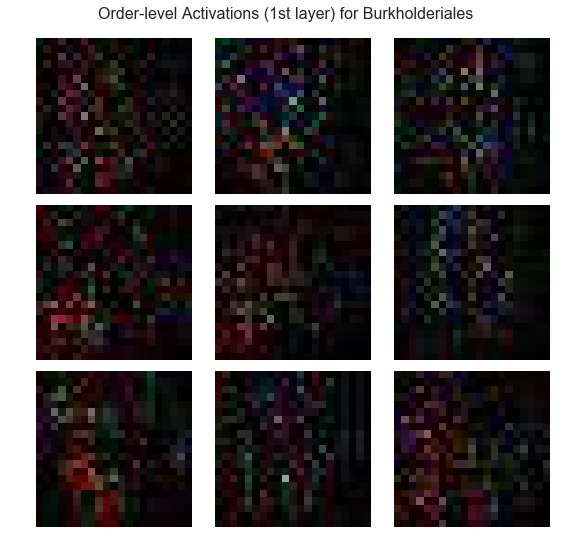

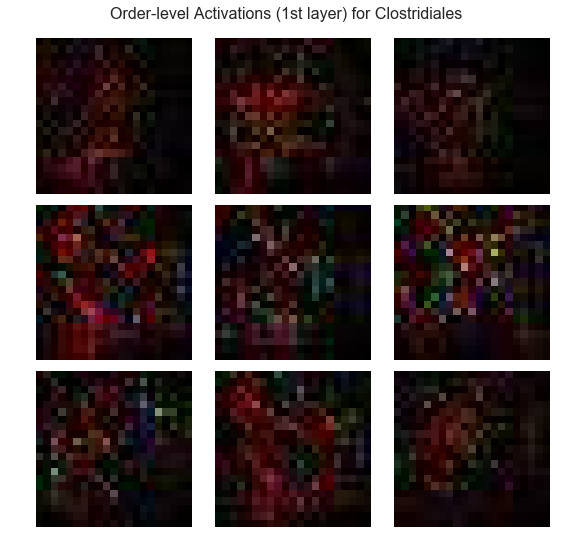

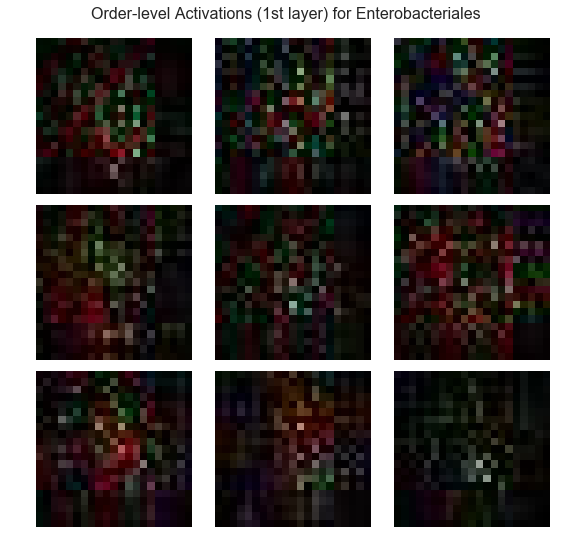

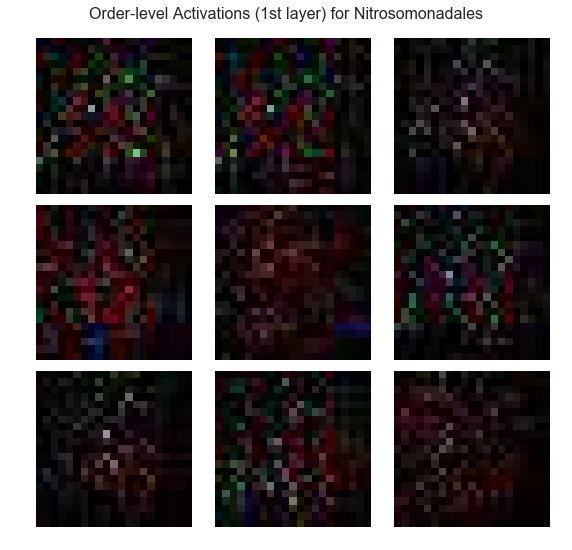

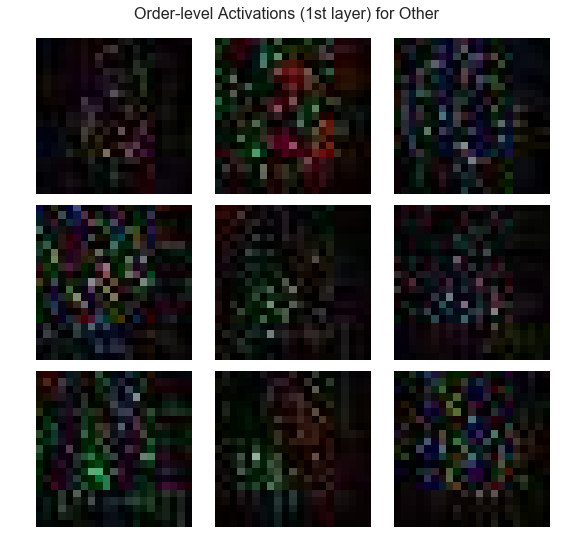

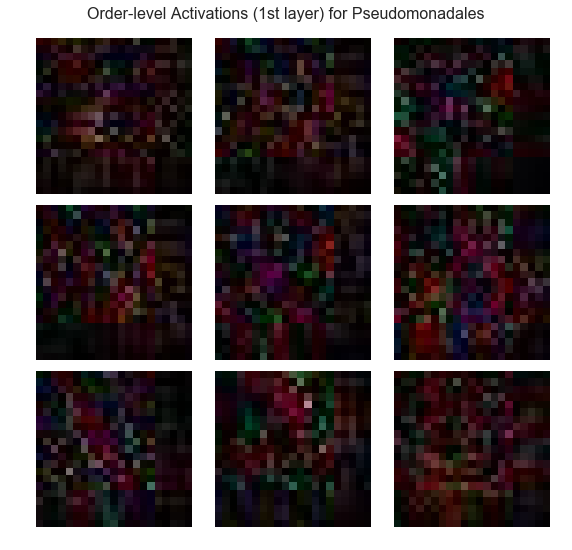

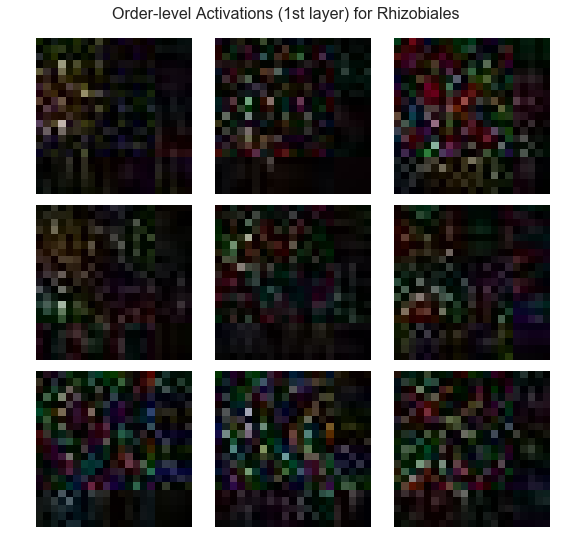

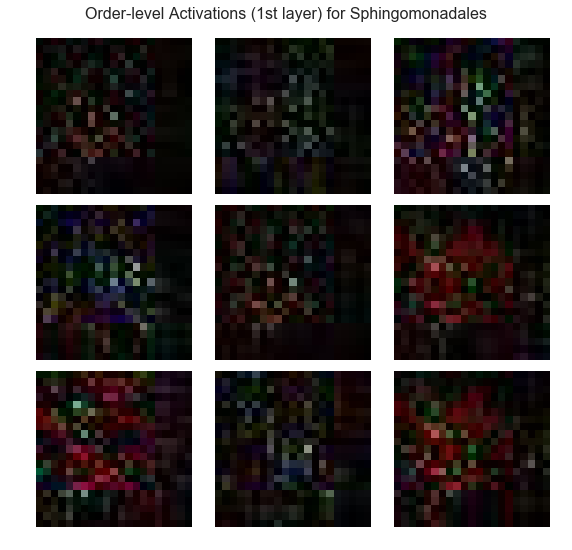

In [22]:
viz_activations_for("order", num_samples_per_class=9)